# MCMC

二次元ガウス分布でMCMC，特にGibbs sampling．

http://machine-learning.hatenablog.com/entry/2016/02/04/201945#f-7050c409

In [1]:
!date

2019年 8月20日 火曜日 16時45分56秒 JST


In [2]:
%matplotlib inline
%matplotlib nbagg

import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.animation import ArtistAnimation
from IPython.display import HTML, display

warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'viridis'
sns.set_context('talk')

# Gaussian distribution

In [3]:
class MultiGauss:
    def __init__(self, mean=[0., 0.], lmd=[[1., 0.5], [0.5, 1.]]):
        
        assert len(mean) == len(lmd)
        
        # Prior
        self._mean = np.array(mean)
        self._lmd = np.array(lmd)  # precision

    def pdf(self, res=None):
        if res is None:
            res = 100

        w, v = np.linalg.eig(self._lmd)
        d = np.arange(res) * (2 * np.pi / res)
        
        c = 1.0
        a = np.sqrt(c * w[0])
        b = np.sqrt(c * w[1])
        
        p1 = a * np.cos(d)
        p2 = b * np.sin(d)
        
        mat = self._mean[:, None] + np.dot(v.T, np.array([p1, p2]))
        
        # Connect first and last points
        mat = np.concatenate([mat, mat.T[0, None].T], axis=1)
        
        return mat
    
    @property
    def mean(self):
        return self._mean
    
    @property
    def lmd(self):
        return self._lmd

In [4]:
class ApproximateGauss:
    def __init__(self, gauss, max_iter=100):

        assert isinstance(gauss, (MultiGauss))
        
        # Distribution
        self.gauss = gauss
        
        # Iteration for MCMC
        self.max_iter = max_iter
        self.iter = 0
        
        # Parameter
        self._mu = np.random.random((2, max_iter))
        
        self._mean = None
        self._lmd = None
        
    def inference(self):
        
        self.iter += 1
        if self.iter >= self.max_iter:
            return
        
        # Sample x0
        mu0 = (self.gauss.mean[0] - self.gauss.lmd[0, 0] ** -1
               * self.gauss.lmd[0, 1] 
               * (self._mu[1, self.iter - 1] - self.gauss.mean[1]))

        self._mu[0, self.iter] = (self.gauss.lmd[0, 0] ** -0.5
                                  * np.random.randn() + mu0)

        # Sample x1
        mu1 = (self.gauss.mean[1] - self.gauss.lmd[1, 1] ** -1
               * self.gauss.lmd[1, 0] 
               * (self._mu[0, self.iter] - self.gauss.mean[0]))
        
        self._mu[1, self.iter] = (self.gauss.lmd[1, 1] ** -0.5
                                  * np.random.randn() + mu1)

    def pdf(self, res=100, c=1.0):

        self._mean = np.mean(self._mu[:, 1:self.iter + 1], axis=1)
        self._lmd = np.cov(self._mu[:, 1:self.iter + 1])
            
        w, v = np.linalg.eig(np.linalg.inv(self._lmd))
        d = np.arange(res) * (2 * np.pi / res)
        
        a = np.sqrt(c * w[0])
        b = np.sqrt(c * w[1])
        
        p1 = a * np.cos(d)
        p2 = b * np.sin(d)
        
        mat = self._mean[:, None] + np.dot(v.T, np.array([p1, p2]))
        
        # Connect first and last points
        mat = np.concatenate([mat, mat.T[0, None].T], axis=1)
        
        return mat
    
    @property
    def mean(self):
        return self._mean
    
    @property
    def lmd(self):
        return self._lmd
    
    @property
    def mu(self):
        return self._mu[:, 1:self.iter + 1]

# Data

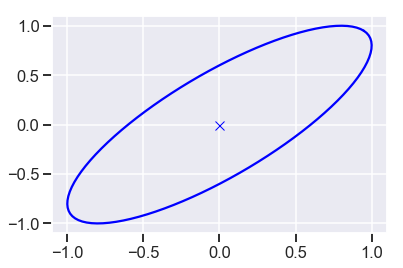

In [5]:
gauss = MultiGauss(lmd=[[1, -0.8], [-0.8, 1]])
mat = gauss.pdf()

plt.plot(mat[0], mat[1], color='b')
plt.plot(*gauss.mean, 'x', color='b')
plt.show()

# MCMC

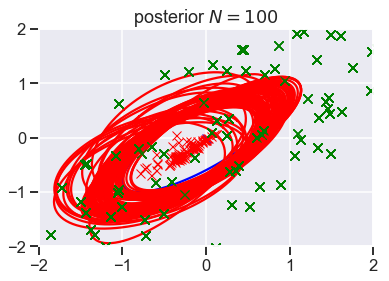

In [8]:
gauss = MultiGauss(lmd=[[1, -0.8], [-0.8, 1]])
dist = ApproximateGauss(gauss)

data = []
frames = []
fig, ax = plt.subplots()
ax.set_title(r'posterior $N = {}$'.format(dist.max_iter))
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.plot(*gauss.pdf(), color='b')
ax.plot(*gauss.mean, 'x', color='b')

for i in range(dist.max_iter):
    dist.inference()
    
    if i > 2:
        im1 = ax.plot(*dist.pdf(), c='r')
        im2 = ax.plot(*dist.mean, 'x', c='r')
        im3 = ax.plot(*dist.mu, 'x', c='g')
        frames.append(im1 + im2 + im3)

In [9]:
ani = ArtistAnimation(fig, frames)
HTML(ani.to_jshtml())